## Libraries

In [1]:
import math
import sys
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
path = Path(os.path.abspath(''))
util_path = str(path.parent.absolute())

if util_path not in sys.path:
    sys.path.append(util_path)
    
from utils import helpers

In [3]:
pd.set_option('display.max_columns',None)
plt.style.use("fivethirtyeight")

## Import Data

In [4]:
def get_marketing_data():
    data = pd.read_csv("../data/raw/bank-full.csv", sep=';')
    return data

In [6]:
df = get_marketing_data()
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [ ]:
print('df shape: {}'.format(df.shape))

In [ ]:
df.describe()

In [ ]:
df.info()

In [ ]:
for column in df.columns:
    print('Column: {} - Unique Values: {}'.format(column, df[column].unique()))

In [ ]:
df.isna().any()

## Pre-processing

In [7]:
# Pre-processing with method chaining

cols_to_category = [
    "job",
    "marital",
    "education",
    "default",
    "housing",
    "loan",
    "contact",
    "month",
    "poutcome",
]
df[cols_to_category] = df[cols_to_category].astype("category")
df["y"] = np.where(df["y"] == "no", 0, 1)

## EDA

1. Visualize all the cols
2. Check for outliers
3. Random forest feature importance
4. Check target distribution
5. Check for missing values

In [8]:
target_name = 'y'
outcome_str = 'uptake'
no_is_good = True
target_color = sns.color_palette(["#e42256", "#00b1b0"])

In [50]:
def percent_stacked_plot_overall(df, target_name):
    # create a figure
    fig = plt.figure(figsize=(11, 6))
    ax = fig.add_subplot(111)

    # proportion of observation of each class
    prop_response = df[target_name].value_counts(normalize=True)

    # create a bar plot showing the percentage of churn
    prop_response.plot(kind='bar',
                       ax=ax,
                       color=['springgreen', 'salmon'])

    # set title and labels
    ax.set_title('Proportion of observations of the response variable',
                 fontsize=18, loc='left')
    ax.set_xlabel('churn',
                  fontsize=14)
    ax.set_ylabel('proportion of observations',
                  fontsize=14)
    ax.tick_params(rotation='auto')

    # eliminate the frame from the plot
    spine_names = ('top', 'right', 'bottom', 'left')
    for spine_name in spine_names:
        ax.spines[spine_name].set_visible(False)


def percentage_stacked_plot(df, target_name, column, ax=None, no_is_good=True):
    # calculate the percentage of observations of the response variable for each group of the independent variable
    # 100% stacked bar plot
    prop_by_independent = pd.crosstab(df[column], df[target_name]).apply(lambda x: x / x.sum() * 100, axis=1)


    if no_is_good:
        color = ["#83d0c9", 'salmon']
    else:
        color = ['salmon', "#83d0c9"]
        
    prop_by_independent.plot(kind='barh', ax=ax, stacked=True,
                             rot=0, color=color)
  
    # set the legend in the upper right corner
    ax.legend(loc="upper right", bbox_to_anchor=(0.62, 0.5, 0.5, 0.5),
              title=target_name, fancybox=True)

    # set title and labels
    ax.set_title('Proportion of observations by ' + column,
                 fontsize=10, loc='left')

    ax.tick_params(rotation='auto')

    # eliminate the frame from the plot
    spine_names = ('top', 'right', 'bottom', 'left')
    for spine_name in spine_names:
        ax.spines[spine_name].set_visible(False)
        

def numerical_dist(df, target_name, col, ax=None, normalize=True):
    selected = df[[col, target_name]]
    target_color = sns.color_palette(["#e42256", "#00b1b0"])

    ## HistPlot1
    sns.histplot(
        stat='percent',
        data=selected,
        kde=True,
        line_kws={"lw": 1.5, "alpha": 0.6},
        common_norm= not normalize,
        x=col,
        bins=20,
        hue=target_name,
        palette=target_color,
        alpha=0.6,
        ax=ax,
    )
    ax.legend(
        title=target_name,
        loc="upper right",
        labels=df[target_name].unique().tolist(),
        ncol=2,
        frameon=True,
        shadow=True,
        title_fontsize=8,
        prop={"size": 7},
        bbox_to_anchor=(1.18, 1.25),
    )
    ax.set_xlabel(str.title(col), fontsize=10)
    ax.set_ylabel("Frequency", fontsize=10)
    ax.set_title(str.title(col) + " distributions", fontsize=12)
    ax.yaxis.set_major_formatter(ticker.EngFormatter())
    

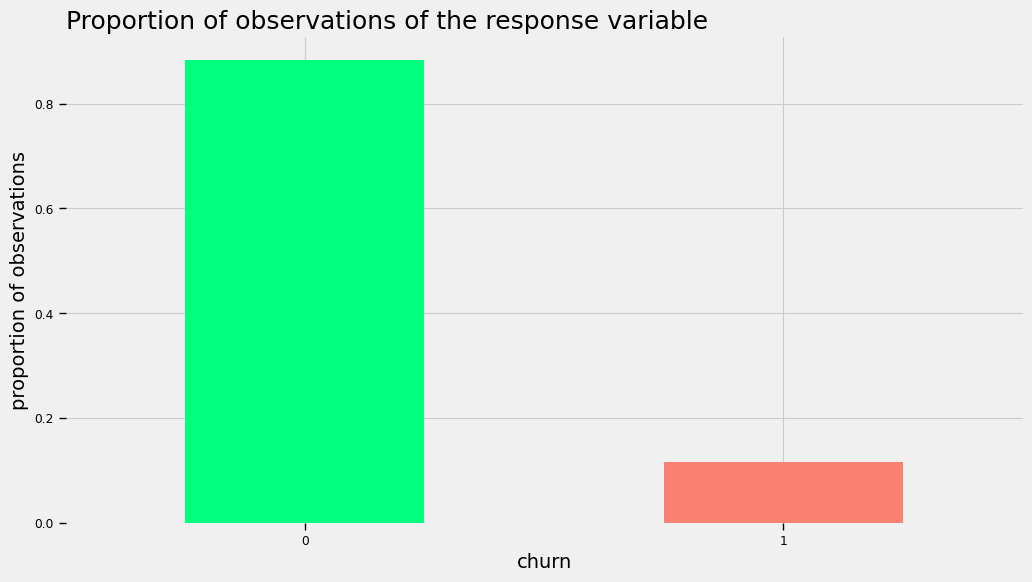

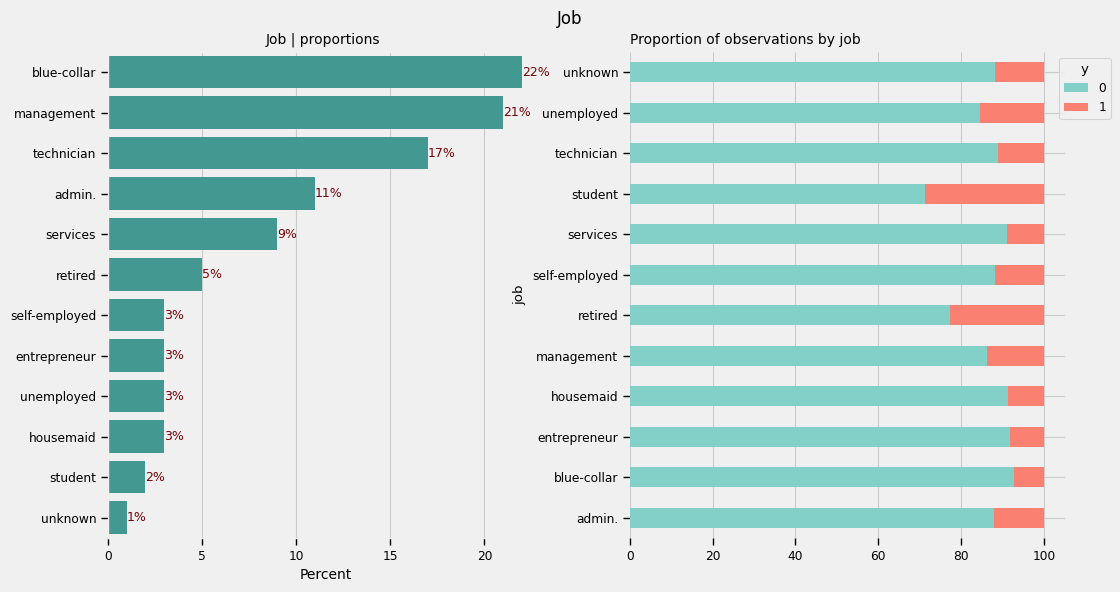

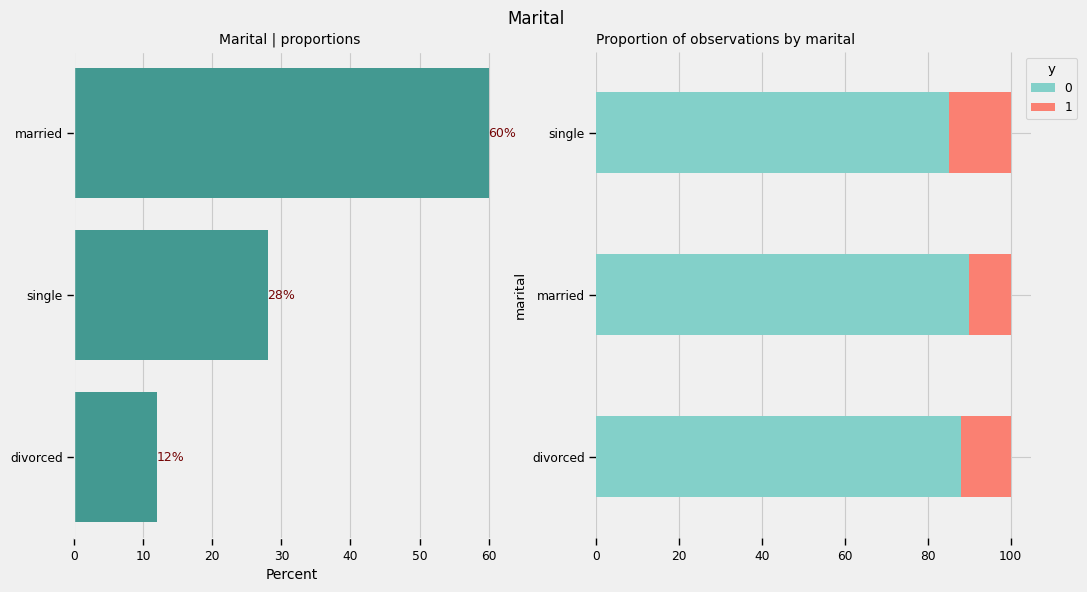

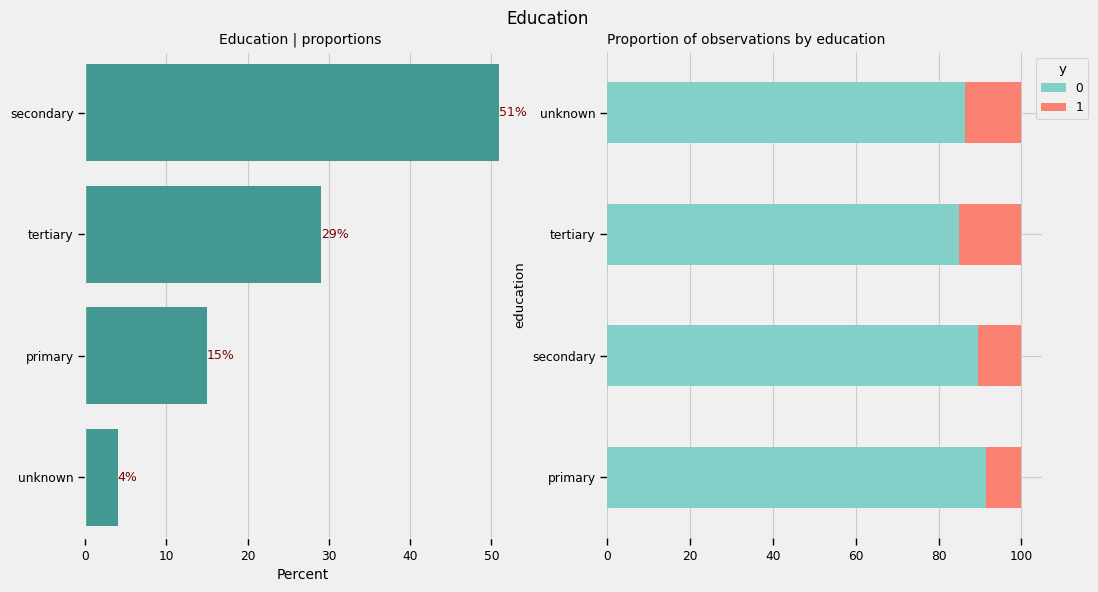

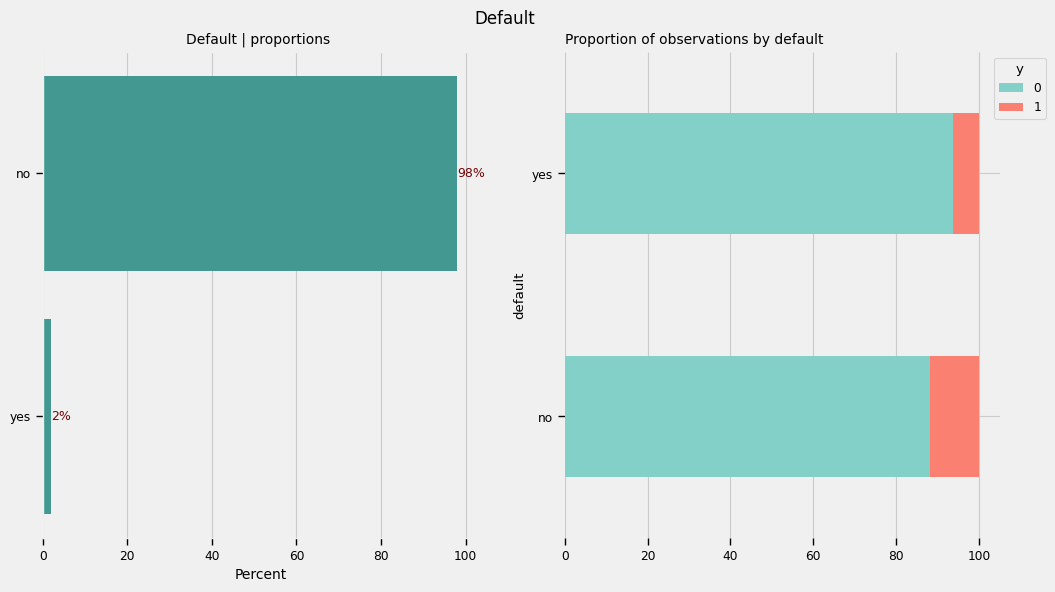

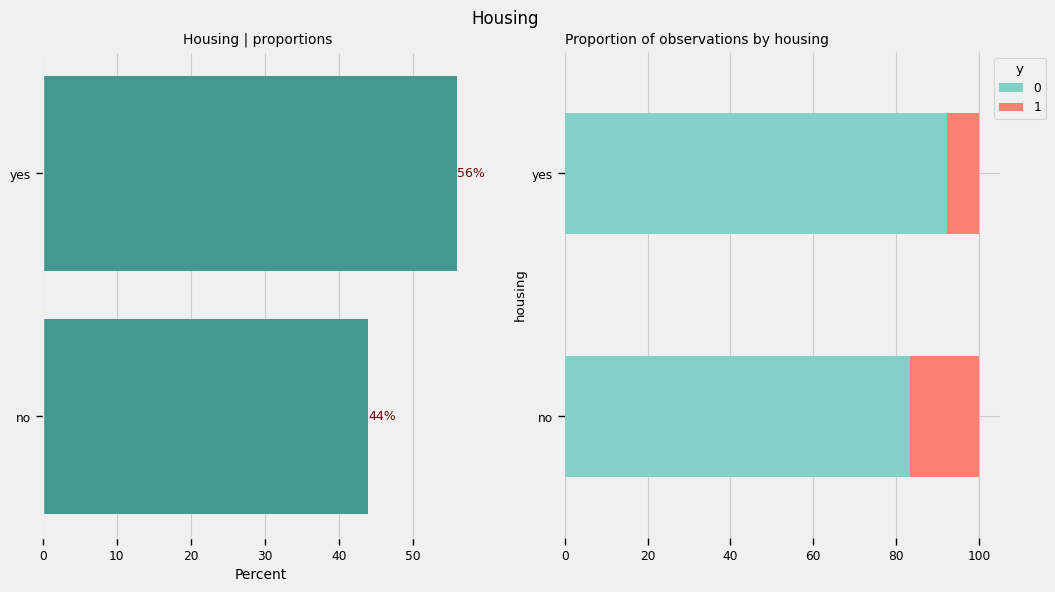

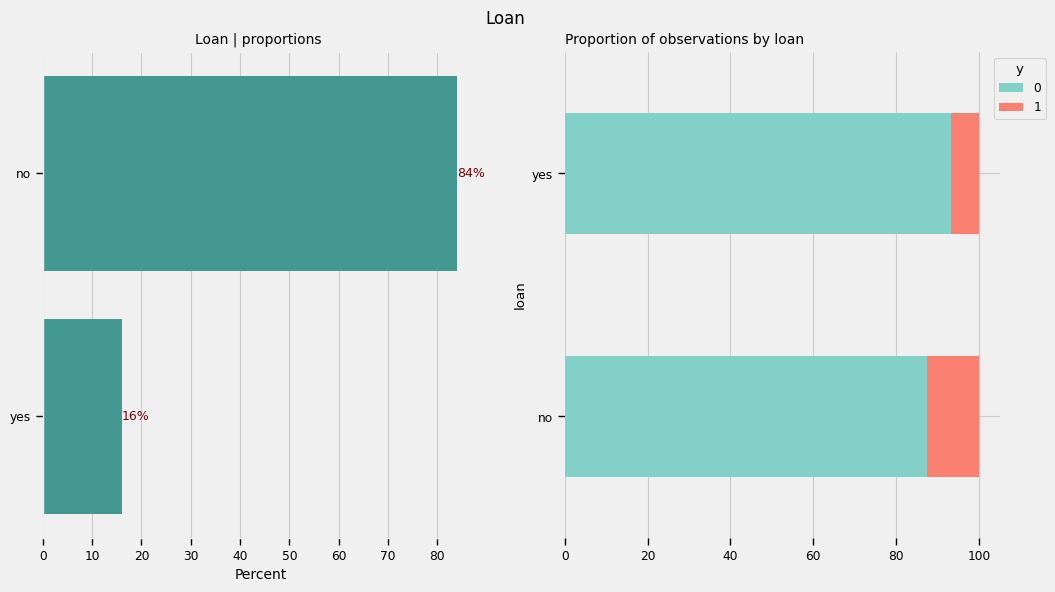

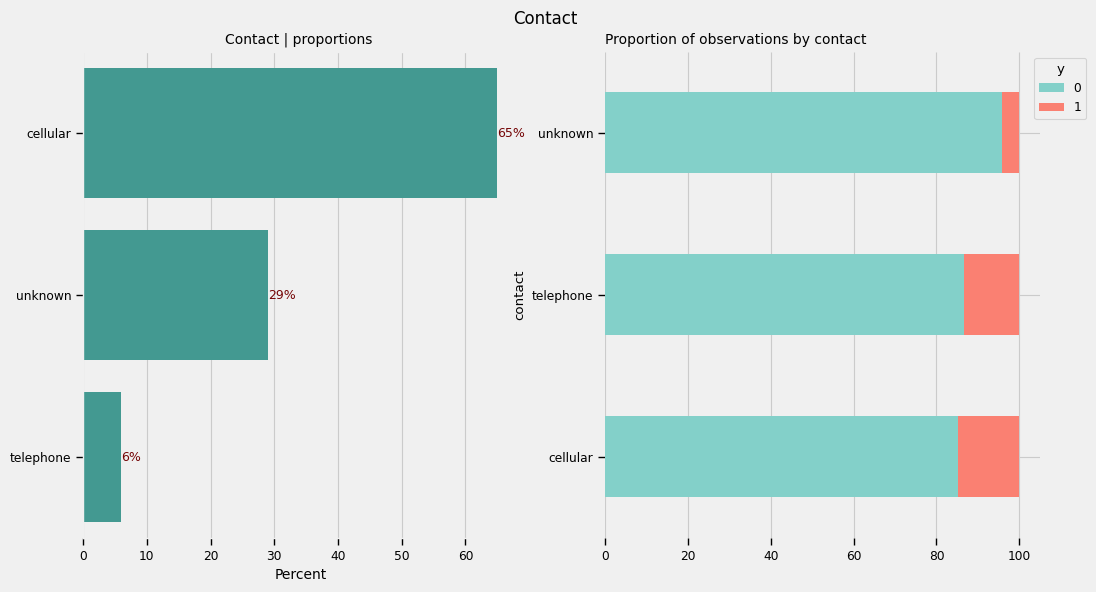

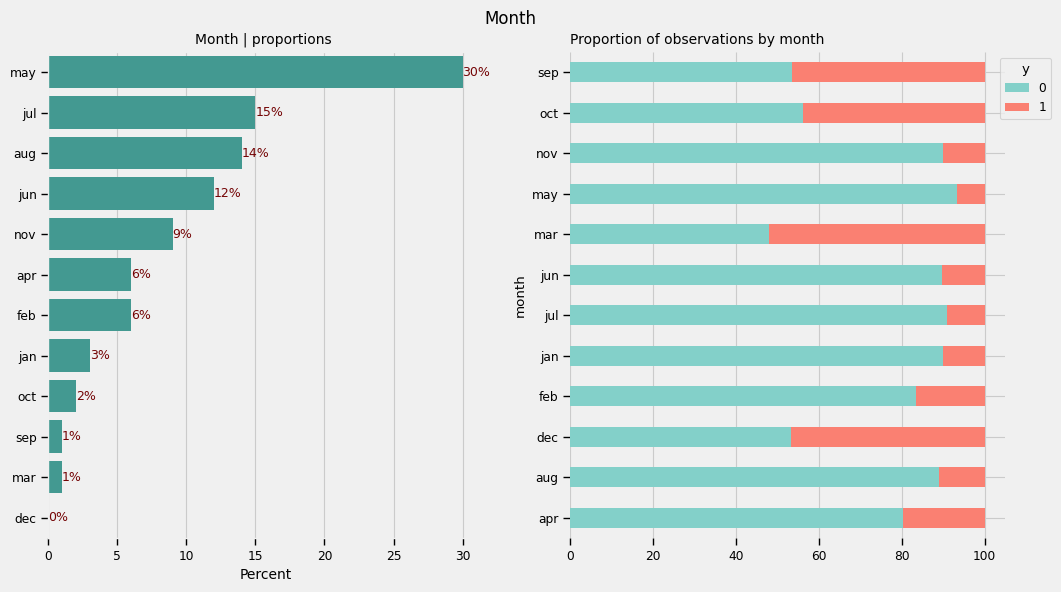

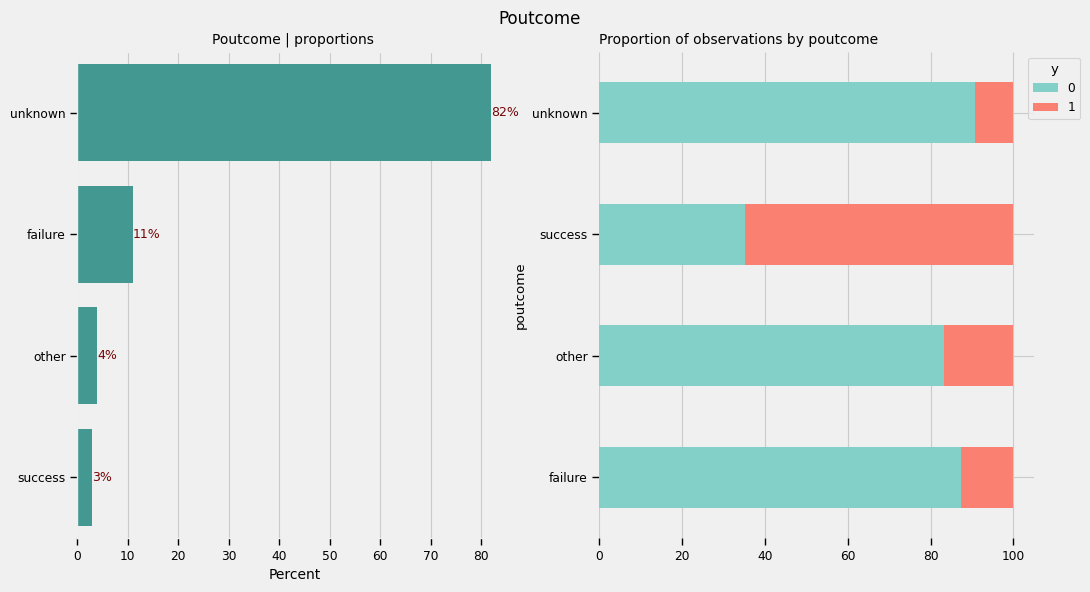

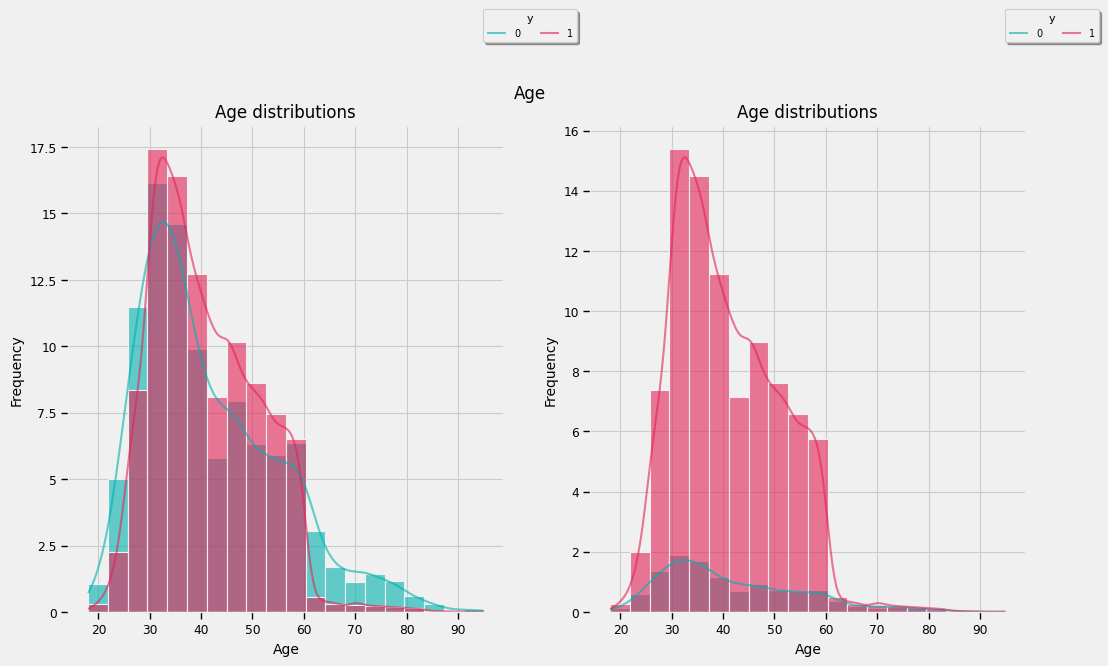

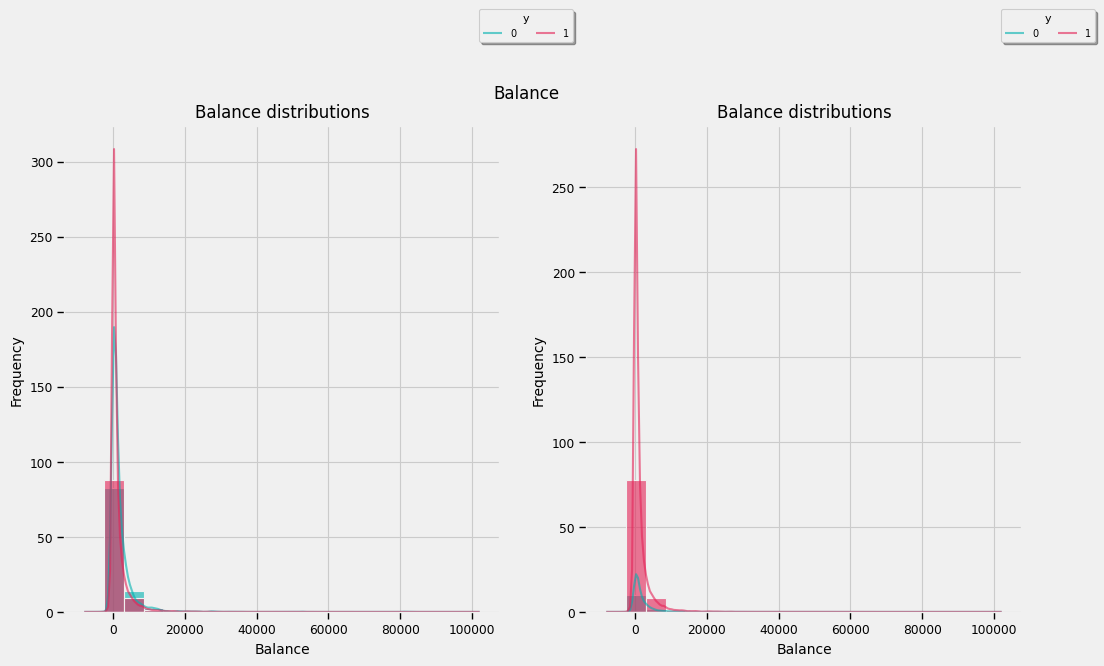

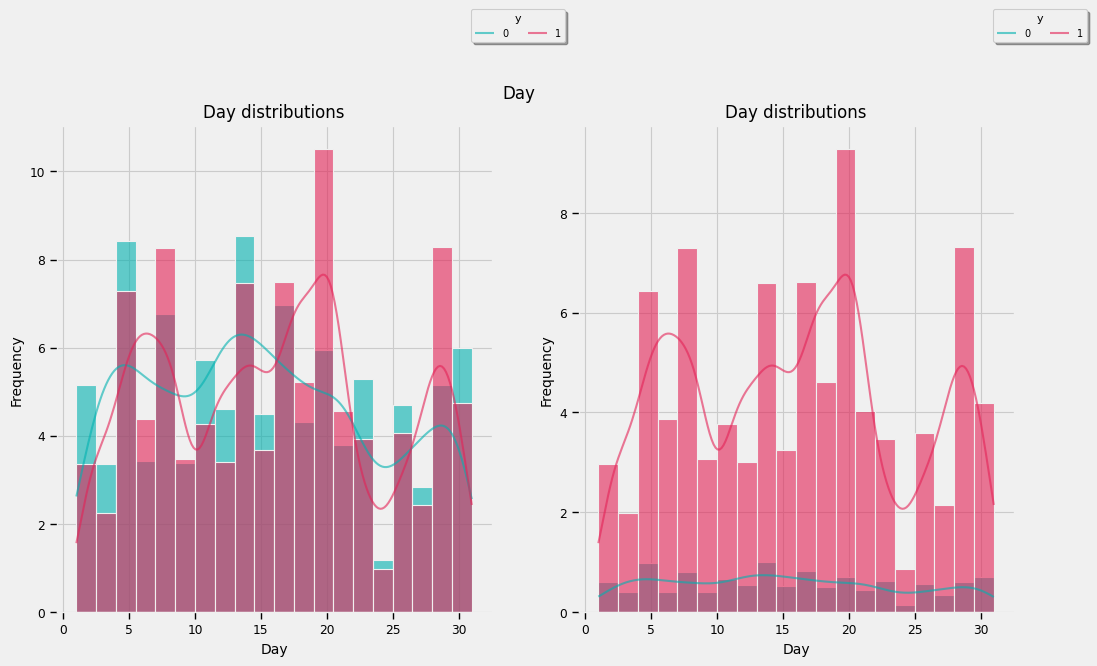

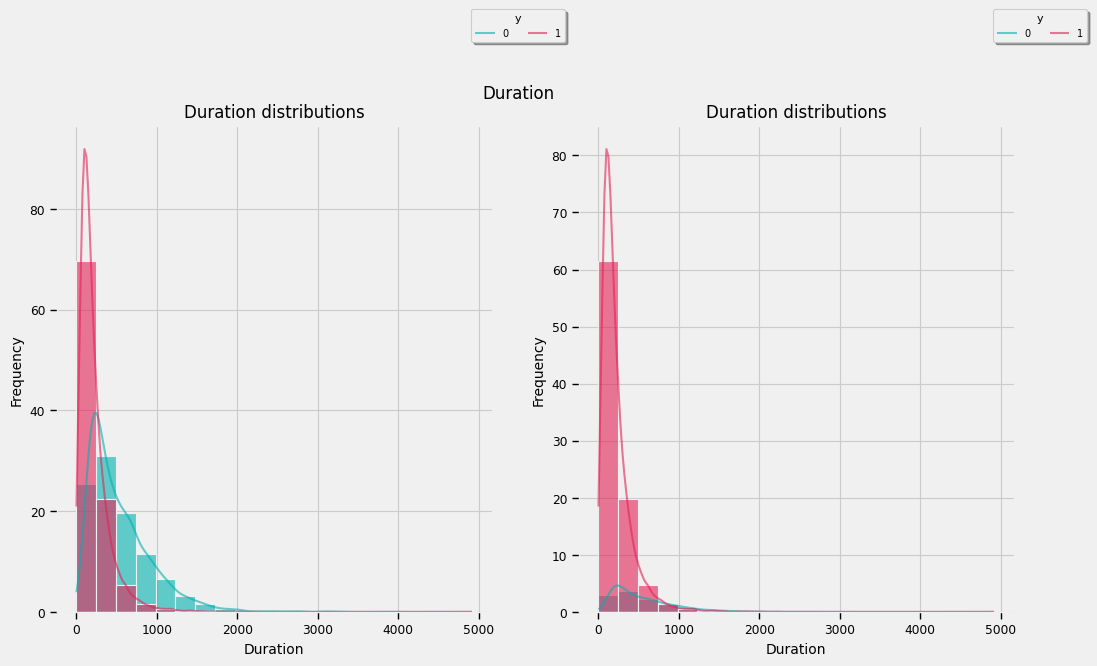

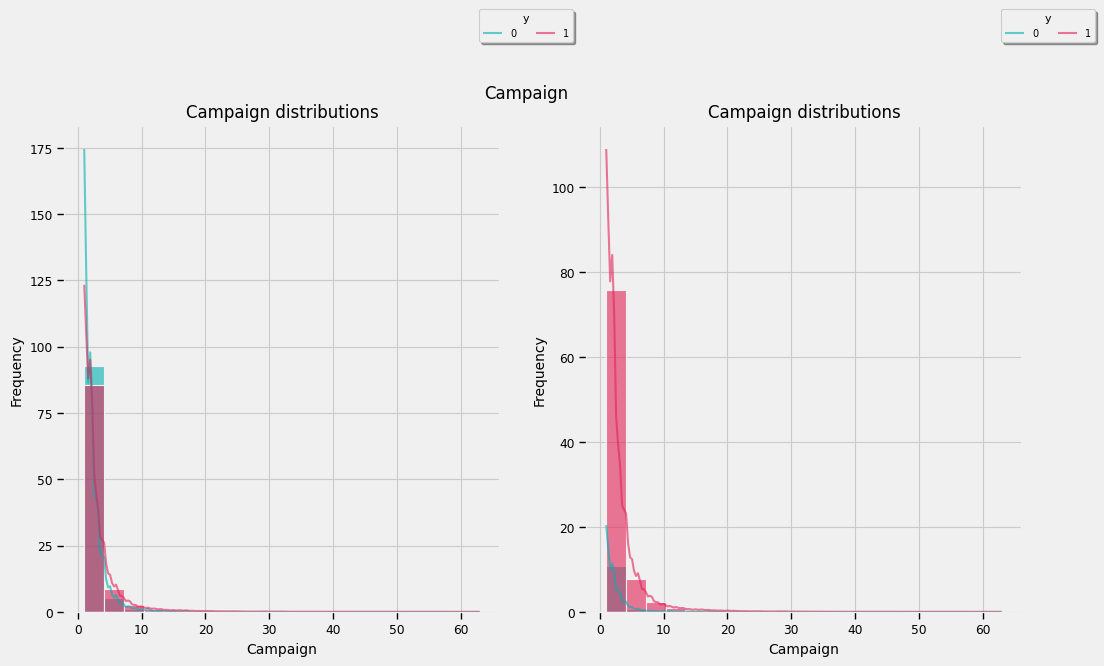

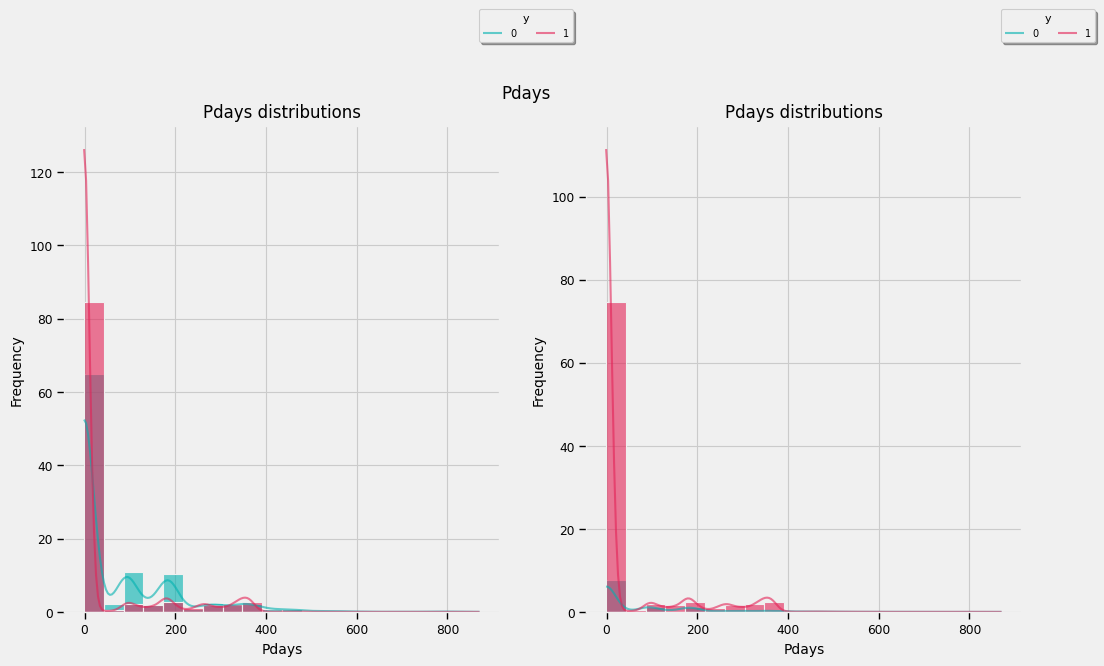

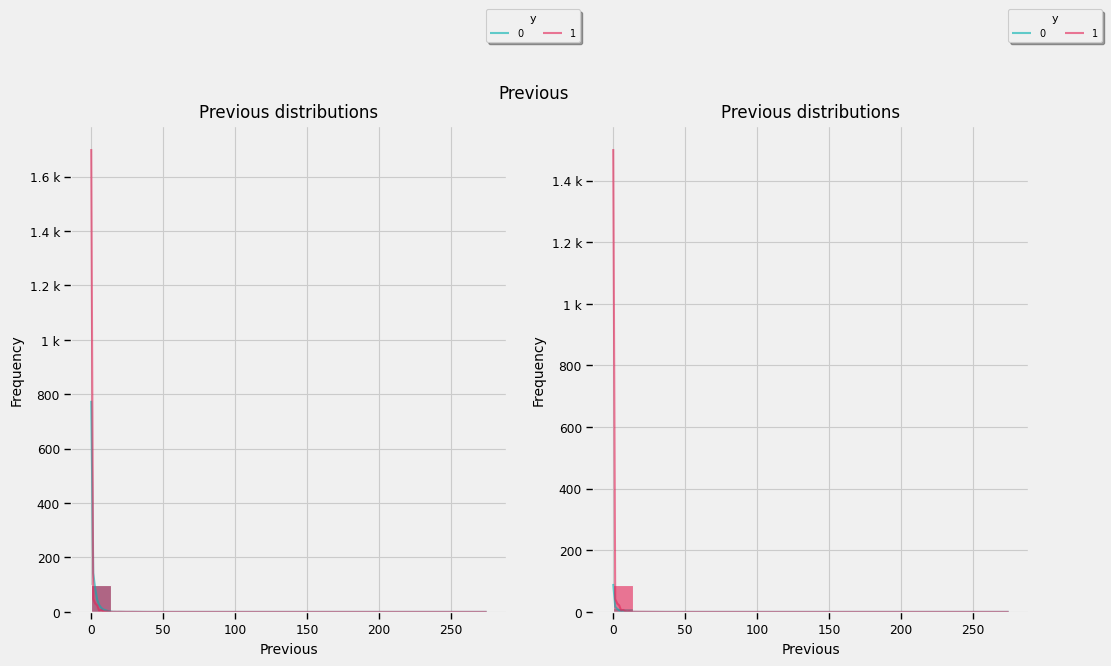

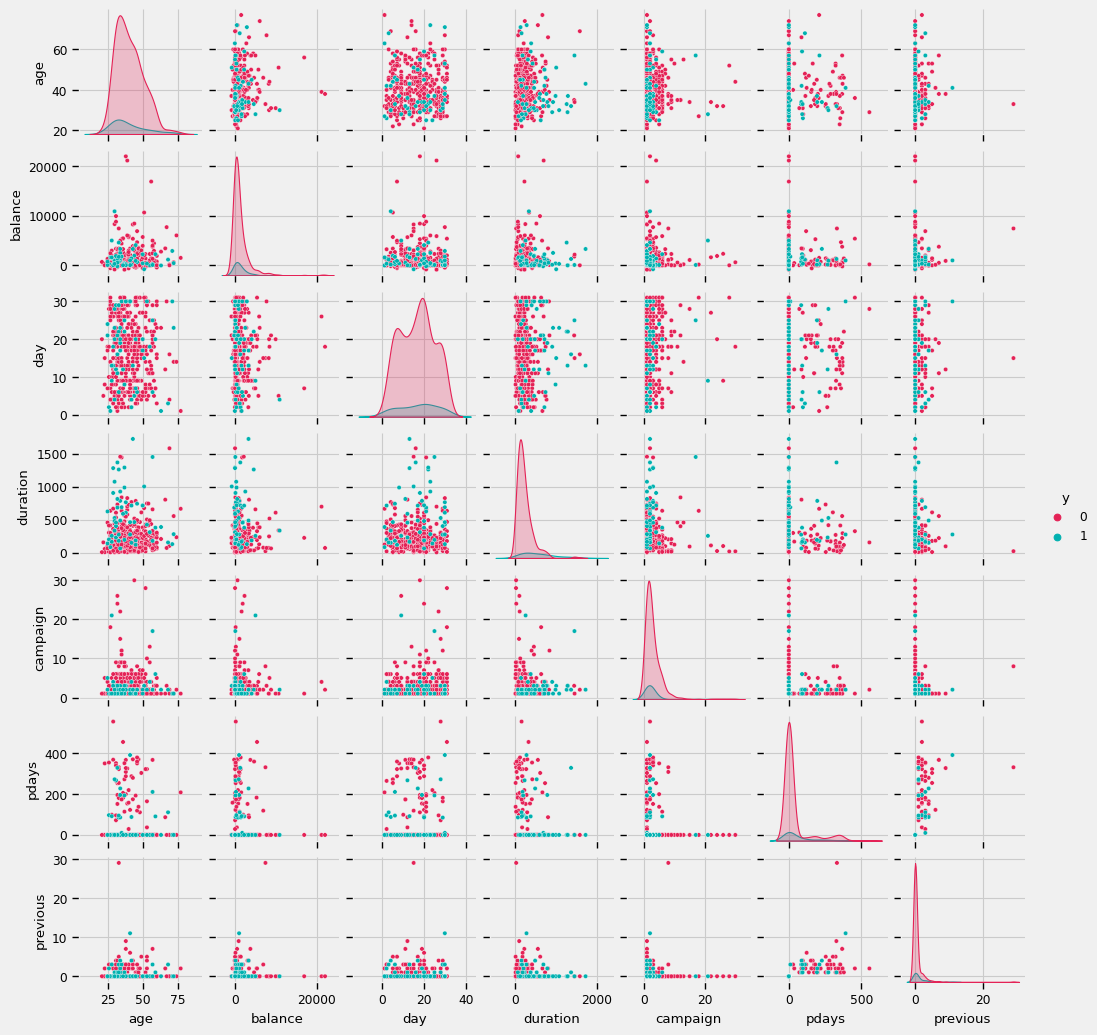

,age,balance,day,duration,campaign,pdays,previous,y
age,nan,nan,nan,nan,nan,nan,nan,nan
balance,0.10,nan,nan,nan,nan,nan,nan,nan
day,-0.01,0.00,nan,nan,nan,nan,nan,nan
duration,-0.00,0.02,-0.03,nan,nan,nan,nan,nan
campaign,0.00,-0.01,0.16,-0.08,nan,nan,nan,nan
pdays,-0.02,0.00,-0.09,-0.00,-0.09,nan,nan,nan
previous,0.00,0.02,-0.05,0.00,-0.03,0.45,nan,nan
y,0.03,0.05,-0.03,0.39,-0.07,0.10,0.09,nan


In [55]:
def init_diagnostic(df, target_name, reclass_target=True):
    numerical_cols = df.select_dtypes(np.number).columns
    cat_cols = df.select_dtypes(exclude=np.number).columns
    
    if reclass_target:
        numerical_cols = [x for x in numerical_cols.tolist()if x != target_name]
        # cat_cols = cat_cols.tolist() + [target_name]
    
    percent_stacked_plot_overall(df, target_name)# FIX COLOURING HERE
    
    # loop through categorical dimensions
    for col in cat_cols:
        # instantiate subplot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6))
        fig.suptitle(col.capitalize(), fontsize=12, y=.95)
        
        # NEED TO FIGURE OUT HOW TO MAKE THIS SHARED AXIS
        # counts
        helpers.counts_plot(df, col, ax=ax1, col="#35a79c")
        
        # 100% stacked
        percentage_stacked_plot(df, target_name, col, ax=ax2)
        
        
    # loop through dimensions
    for col in numerical_cols:
        # instantiate subplot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6))
        fig.suptitle(col.capitalize(), fontsize=12, y=.95)
        
        # distribution 
        numerical_dist(df, target_name, col, ax=ax1)
        
        # distribution (not-normalized)
        numerical_dist(df, target_name, col, normalize=False, ax=ax2)


    # correlations and multi-feature explorations
    helpers.pairplot(df, target_name)
    #helpers.mutual_information_plot(df, target_name) # need to re-convert this into a category...
    #feature importance
    return helpers.corr_matrix(df)
    
init_diagnostic(df, target_name)